In [6]:
import pandas as pd

import os
print(os.getcwd())
os.chdir('/mnt/c/Users/ZTaylor/mlcas')
print(os.getcwd())


/mnt/c/Users/ZTaylor/mlcas
/mnt/c/Users/ZTaylor/mlcas


/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Internal Test RMSE: 23.763515958932967
Feature Importances:
                    Feature  Importance
173        location_Lincoln    0.558642
69          RedEdge_sum_TP2    0.044364
68       RedEdge_median_TP2    0.040004
22                      row    0.030381
9                      ECEC    0.020095
..                      ...         ...
228       genotype_K64 X 66    0.000000
230       genotype_K64 X B7    0.000000
234      genotype_K64 X KYS    0.000000
267  genotype_PHG39 X PHN82    0.000000
187      experiment_hybrids    0.000000

[312 rows x 2 columns]


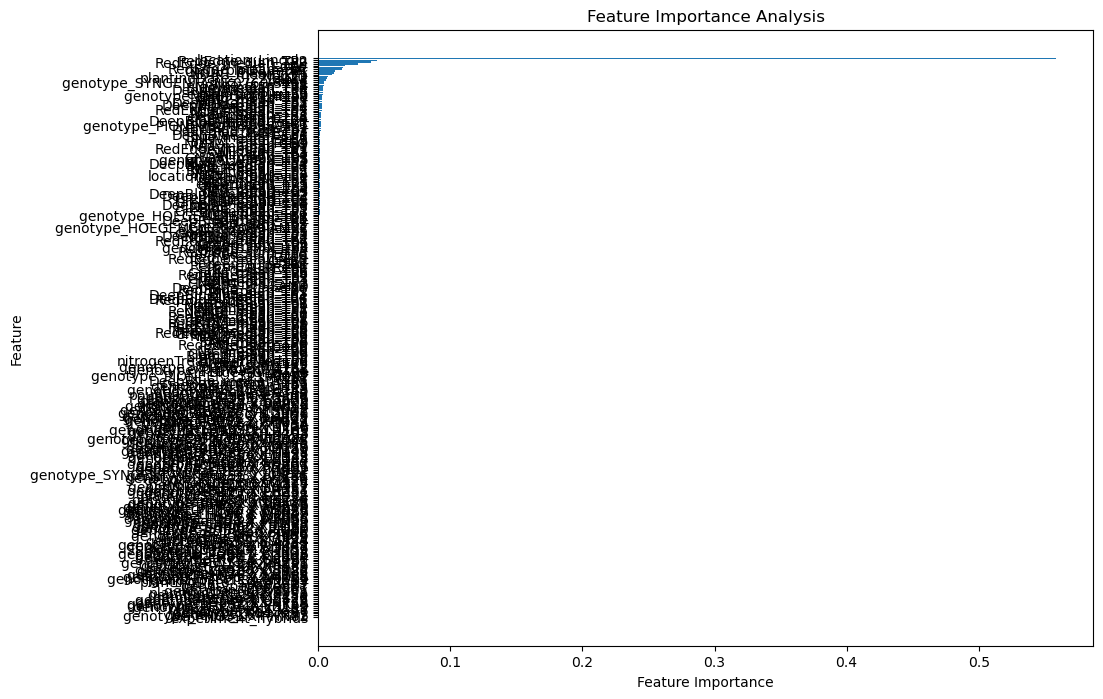

Validation predictions saved to 'Validation_Predictions.csv'.
Validation predictions saved to 'Validation_Predictions.csv'.


In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the training dataset
train_file_path = 'TRANING_DF_1.csv'
df_train = pd.read_csv(train_file_path)

# Load the validation dataset
validation_file_path = 'TESTT.csv'
df_validation = pd.read_csv(validation_file_path)

# Ensure 'plotnumber' is not dropped from validation data
columns_to_drop = ['index_x', 'qrCode']

df_train_clean = df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns])
df_validation_clean = df_validation.drop(columns=[col for col in columns_to_drop if col in df_validation.columns])

# Extract plotnumber column for later use
plot_numbers = df_validation_clean['plotNumber']

# Identify non-numeric columns
non_numeric_columns = df_train_clean.select_dtypes(include=['object']).columns

# Convert categorical columns to dummy variables
df_train_encoded = pd.get_dummies(df_train_clean, columns=non_numeric_columns, drop_first=True)
df_validation_encoded = pd.get_dummies(df_validation_clean, columns=non_numeric_columns, drop_first=True)

# Align validation dataset with training dataset columns (handle any mismatch)
df_validation_encoded = df_validation_encoded.reindex(columns=df_train_encoded.columns.drop('yieldPerAcre'), fill_value=0)

# Handle missing values by imputing with the median for numerical columns
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(df_train_encoded.drop(columns=['yieldPerAcre']))
X_validation_imputed = imputer.transform(df_validation_encoded)
y_train = df_train_encoded['yieldPerAcre']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validation_scaled = scaler.transform(X_validation_imputed)

# Split the training data into training and testing sets (for internal validation)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the internal test set
y_test_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Internal Test RMSE: {rmse_test}")

# Feature importance analysis
feature_importances = model.feature_importances_
features = df_train_encoded.drop(columns=['yieldPerAcre']).columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the features sorted by importance
print("Feature Importances:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Analysis")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

# Predict on the validation set
y_validation_pred = model.predict(X_validation_scaled)

# Output the predictions for the validation dataset, including the plotnumber
validation_results = pd.DataFrame({
    'plotnumber': plot_numbers,
    'Predicted_YieldPerAcre': y_validation_pred
})

# Save the results to a CSV file
validation_results.to_csv('Validation_Predictions.csv', index=False)
print("Validation predictions saved to 'Validation_Predictions.csv'.")


importance_df.to_csv('importance_df.csv', index=False)
print("Validation predictions saved to 'Validation_Predictions.csv'.")
